In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

import nltk
import string
import re

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/christesont/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/christesont/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
sw = set(nltk.corpus.stopwords.words('english'))

def clean(text, stopwords):
    # remove tags like <tab>    
    text = re.sub(r'<[^<>]*>', ' ', text)  
    # split text on whitespace
    text_list = text.split()
    text_words = []
    
    punctuation = set(string.punctuation)
    
    # keep #tags and @mentions 
    ## punctuation.remove("#")
    ## punctuation.remove("@")
    
    for word in text_list:
        # remove punctuation marks at the beginning  
        # of each word
        while len(word) > 0 and word[0] in punctuation:
            word = word[1:]
        
        # remove punctuation marks at the end of each word
        while len(word) > 0 and word[-1] in punctuation:
            word = word[:-1]
        
        # a rule to eliminate most urls 
        if len(word) > 0 and "/" not in word:
            # eliminate stopwords 
            if word.lower() not in stopwords:
                # append the word to the text_words list
                text_words.append(word.lower())
        cleaner_text = " ".join(text_words)
    return cleaner_text

In [3]:
def ingest_and_clean_data():
    from pathlib import Path

    file_list_pos = [path for path in Path('imdb').rglob('*/pos/*.txt')]
    file_list_neg = [path for path in Path('imdb').rglob('*/neg/*.txt')]

    corpus_positive = [open(f, encoding="utf8").read() for f in file_list_pos]
    corpus_negative = [open(f, encoding="utf8").read() for f in file_list_neg]

    df = pd.DataFrame(corpus_positive, columns=['text'])
    df['sentiment'] = 'pos'

    df2 = pd.DataFrame(corpus_negative, columns=['text'])
    df2['sentiment'] = 'neg'

    df = df.append(df2)

    df['length'] = df.text.str.len()
    df = df[df.length >= 100]
    df.drop(['length'], axis=1, inplace=True)

    print(df.iloc[0])
    df['text'] = df['text'].apply(clean, stopwords=sw)
    print(df.iloc[0])

    df.to_pickle('reviews.pkl')

In [4]:
df = pd.read_pickle('reviews.pkl')
# df['sentiment']=(df['sentiment']=='pos').astype(int)
df

,text,sentiment
0,went saw movie last night coaxed friends mine ...,pos
1,actor turned director bill paxton follows prom...,pos
2,recreational golfer knowledge sport's history ...,pos
3,saw film sneak preview delightful cinematograp...,pos
4,bill paxton taken true story 1913 us golf open...,pos
...,...,...
24995,towards end movie felt technical felt like cla...,neg
24996,kind movie enemies content watch time bloody t...,neg
24997,saw descent last night stockholm film festival...,neg
24998,films pick pound turn rather good 23rd century...,neg


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.3, random_state=123)

Trying Multinomial Naive Bayes

The train set accuracy is 0.8628021530314935


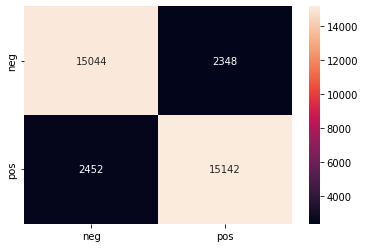

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score 
from sklearn.model_selection import cross_val_score, cross_val_predict

pipe_nb = Pipeline([('tfidf', TfidfVectorizer(stop_words="english")), ('clf', MultinomialNB())])

pipe_nb.fit(X_train, y_train)

cv_acc_score = np.mean(cross_val_score(pipe_nb, X_train, y_train, scoring='accuracy'))

# predicted_sentiment = pipe_nb.predict(X_test)

predicted_sentiment_train = cross_val_predict(pipe_nb,X_train,y_train)



cm = confusion_matrix(y_train, predicted_sentiment_train)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])


print(f"The train set accuracy is {cv_acc_score}")
# print(f"The test set accuracy is {accuracy_score(y_test, predicted_sentiment)}")

In [7]:
len(pipe_nb.steps[0][1].get_feature_names())

/mnt/c/users/chris/desktop/atomprojects/cs4448/cs4448/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


86944

Trying Support Vector Machine

from sklearn.svm import SVC

pipe_svc = Pipeline([('tfidf', TfidfVectorizer(stop_words="english")), ('clf', SVC())])

pipe_svc.fit(X_train, y_train)

predicted_sentiment = pipe_svc.predict(X_test)


cm = confusion_matrix(y_test, predicted_sentiment)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])


predicted_sentiment_train = pipe_svc.predict(X_train)

print(f"The train set accuracy is {accuracy_score(y_train, predicted_sentiment_train)}")
print(f"The test set accuracy is {accuracy_score(y_test, predicted_sentiment)}")

Trying Random Forest

The train set accuracy is 0.8515692860325597


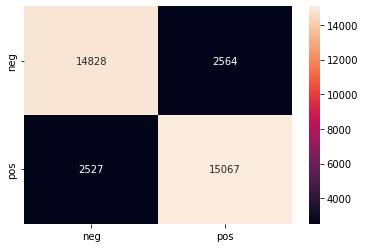

In [8]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline([('tfidf', TfidfVectorizer(stop_words="english")), ('clf', RandomForestClassifier(n_jobs=5))])

pipe_rf.fit(X_train, y_train)

cv_acc_score = np.mean(cross_val_score(pipe_rf, X_train, y_train, scoring='accuracy'))

# predicted_sentiment = pipe_nb.predict(X_test)

predicted_sentiment_train = cross_val_predict(pipe_rf,X_train,y_train)

cm = confusion_matrix(y_train, predicted_sentiment_train)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])

print(f"The train set accuracy is {cv_acc_score}")
# print(f"The test set accuracy is {accuracy_score(y_test, predicted_sentiment)}")

Trying XGBoost

The train set accuracy is 0.8489967712860078


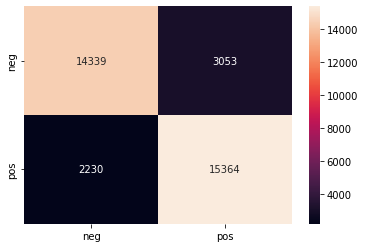

In [9]:
from xgboost import XGBClassifier
pipe_xgb = Pipeline([('tfidf', TfidfVectorizer(stop_words="english")),
                     ('clf', XGBClassifier(objective='binary:logistic', use_label_encoder=True,eval_metric='error',n_jobs=5))])


import warnings
warnings.filterwarnings("ignore") #ignore lot of xgb UserWarnings that don't affect results

pipe_xgb.fit(X_train, y_train)

cv_acc_score = np.mean(cross_val_score(pipe_xgb, X_train, y_train, scoring='accuracy'))

# predicted_sentiment = pipe_nb.predict(X_test)
predicted_sentiment_train = cross_val_predict(pipe_xgb,X_train,y_train)
warnings.filterwarnings("default")

cm = confusion_matrix(y_train, predicted_sentiment_train)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])

print(f"The train set accuracy is {cv_acc_score}")
# print(f"The test set accuracy is {accuracy_score(y_test, predicted_sentiment)}")

## After cross-validation on the Training set: 
Multinomial Naive Bayes had the best accuracy across the 5 cross-validation folds (approximately 86%).  

Hyperparameter Tuning Naive Bayes

In [10]:
from sklearn.model_selection import GridSearchCV

parameters = {
    #'tfidf__max_features': (1000, 2000, 5000, 10000),
#     'tfidf__min_df': (0, 0.1, 0.25),
#     'tfidf__max_df': (0.26, 0.5, 0.75, 1),
#     'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': (10, 5, 2, 1, 0.1, 1e-2, 1e-3)
}

grid_search = GridSearchCV(pipe_nb, parameters, cv=5,n_jobs=5)
grid_search.fit(X_train, y_train)

predicted_sentiment = grid_search.predict(X_test)
predicted_sentiment_train = grid_search.predict(X_train)

The train set accuracy is 0.910764305722289
The test set accuracy is 0.8692143524076297
Best Parameters: {'clf__alpha': 1}


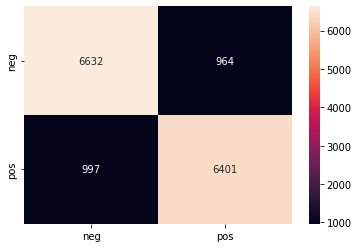

In [11]:
from sklearn.metrics import accuracy_score
print(f"The train set accuracy is {accuracy_score(y_train, predicted_sentiment_train)}")
print(f"The test set accuracy is {accuracy_score(y_test, predicted_sentiment)}")

cm = confusion_matrix(y_test, predicted_sentiment)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])
print(f"Best Parameters: {grid_search.best_params_}")

Hyperparameter Tuning Random Forest

parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__n_estimators': (50, 100, 150, 200)
}

grid_search = GridSearchCV(pipe_rf, parameters, cv=5, n_jobs=12)
grid_search.fit(X_train, y_train)

predicted_sentiment = grid_search.predict(X_test)


cm = confusion_matrix(y_test, predicted_sentiment)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])


predicted_sentiment_train = grid_search.predict(X_train)

print(f"The train set accuracy is {accuracy_score(y_train, predicted_sentiment_train)}")
print(f"The test set accuracy is {accuracy_score(y_test, predicted_sentiment)}")

print(f"Best Parameters: {grid_search.best_params_}")

Hyperparameter Tuning XGBoost

parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__n_estimators': (50, 100, 150, 200)
}

grid_search = GridSearchCV(pipe_xgb, parameters, cv=5)
grid_search.fit(X_train, y_train)

predicted_sentiment = grid_search.predict(X_test)


cm = confusion_matrix(y_test, predicted_sentiment)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])


predicted_sentiment_train = grid_search.predict(X_train)

print(f"The train set accuracy is {accuracy_score(y_train, predicted_sentiment_train)}")
print(f"The test set accuracy is {accuracy_score(y_test, predicted_sentiment)}")

print(f"Best Parameters: {grid_search.best_params_}")